In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
#import seaborn as sns
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
import torch
import mctorch.nn as mnn
import mctorch.optim as moptim

import OurMethod

## Prepare the Data

In [2]:
# read in the dataframe
df = pd.read_csv("Data/penguins.csv")

In [3]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [4]:
df['species'].unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

In [5]:
# Make the targets integers.
df['target'] = [list(df['species'].unique()).index(b) for b in list(df['species'])]

In [6]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,target
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,0
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,0
...,...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009,2
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009,2
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009,2
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009,2


In [7]:
print(len(df[df['species']=='Adelie']))
print(len(df[df['species']=='Gentoo']))
print(len(df[df['species']=='Chinstrap']))

152
124
68


In [8]:
df[df['bill_length_mm'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,target
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007,0
271,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN,2009,1


In [9]:
# Drop columns with missing values.
df = df.dropna()

In [10]:
# Prepare to standardize the data.
myscaler = pre.StandardScaler(copy=False)

In [11]:
# Prepare the data, split into test/train
#Xdf = pd.DataFrame(data=df, columns=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])
Xdf = pd.DataFrame(data=df, columns=['bill_length_mm', 'bill_depth_mm'])
#Xdf = pd.DataFrame(data=df[df['species']!='Gentoo'], columns=['bill_length_mm', 'body_mass_g'])
Ydf = pd.DataFrame(data=df, columns=['target'])
#Ydf = pd.DataFrame(data=df[df['species']!='Gentoo'], columns=['target'])

X = Xdf.to_numpy()
# myscaler.fit_transform(X) # oops: don't fit on the test data!
Y = Ydf.to_numpy()


# These are created for later visualization
X0 = np.array([X[i] for i in range(len(X)) if Y[i][0]==0])
Y0 = np.array([Y[i] for i in range(len(Y)) if Y[i][0]==0])
X1 = np.array([X[i] for i in range(len(X)) if Y[i][0]==1])
Y1 = np.array([Y[i] for i in range(len(Y)) if Y[i][0]==1])
X2 = np.array([X[i] for i in range(len(X)) if Y[i][0]==2])
Y2 = np.array([Y[i] for i in range(len(Y)) if Y[i][0]==2])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

myscaler.fit(X_train) # compute mean, stdev.
myscaler.transform(X_train) # standardize training data
myscaler.transform(X_test) # standardize test data.
eX = np.append(X_train,X_test,axis=0)
whY = np.append(y_train,y_test,axis=0)

for i in range(3): # transform the class datasets.
    myscaler.transform(eval("X" + str(i)))

In [12]:
#plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [43]:
font = {'size'   : 18}

plt.rc('font', **font)


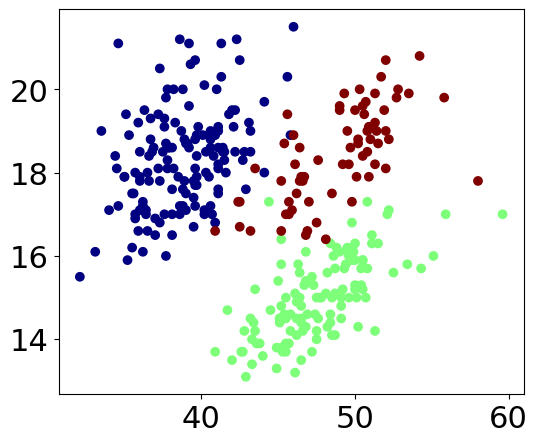

In [41]:
plt.figure(figsize=(6,5))
plt.scatter(X.transpose()[0],X.transpose()[1],c=Y, cmap='jet')
#plt.legend()
plt.show()

In [14]:
# Logistic regression in sklearn wants different shapes for targets...
y_train = y_train.reshape(y_train.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)

## Apply SVM

In [15]:
svc = SVC(kernel='poly',degree=1,probability=True)
svc.fit(X_train, y_train)

SVC(degree=1, kernel='poly', probability=True)

In [16]:
svc.score(X_test, y_test)

0.9402985074626866

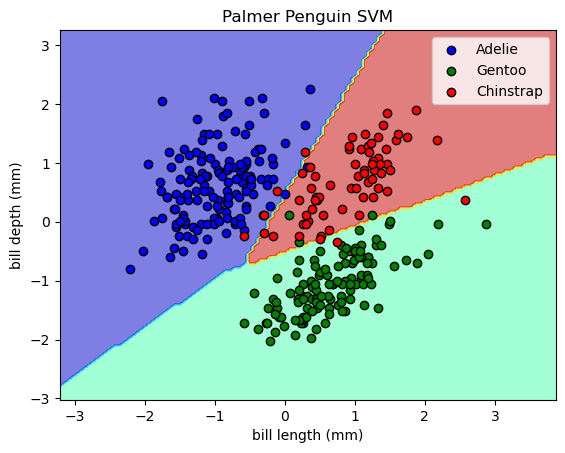

In [17]:
disp = DecisionBoundaryDisplay.from_estimator(svc, X_train, response_method="predict", cmap='jet',
                                              xlabel='bill length (mm)', ylabel='bill depth (mm)',alpha=0.5)
disp.ax_.scatter(X0[:, 0], X0[:, 1], c='blue', edgecolor="k", label='Adelie')
disp.ax_.scatter(X1[:, 0], X1[:, 1], c='green', edgecolor="k", label='Gentoo')
disp.ax_.scatter(X2[:, 0], X2[:, 1], c='red', edgecolor="k", label='Chinstrap')
disp.ax_.legend()
plt.title("Palmer Penguin SVM")
#plt.savefig("SVM.png")
#plt.savefig("SVM.pdf")
plt.show()

In [18]:
probs = svc.predict_proba(eX)

In [19]:
probs

array([[8.56207874e-07, 9.99391850e-01, 6.07293564e-04],
       [9.96610599e-01, 1.61952894e-03, 1.76987172e-03],
       [6.60597919e-01, 7.52570601e-02, 2.64145021e-01],
       [9.99887815e-01, 5.23954727e-05, 5.97897090e-05],
       [9.88989403e-01, 1.24229009e-03, 9.76830677e-03],
       [1.73340164e-05, 9.95476834e-01, 4.50583243e-03],
       [2.13735190e-03, 9.13802931e-04, 9.96948845e-01],
       [7.61970844e-03, 9.81311929e-01, 1.10683622e-02],
       [3.77068573e-03, 9.91848966e-01, 4.38034867e-03],
       [9.99113583e-01, 2.00526038e-04, 6.85891070e-04],
       [9.99950125e-01, 9.77974442e-06, 4.00950137e-05],
       [9.96855474e-01, 1.21461344e-03, 1.92991293e-03],
       [3.77518923e-03, 9.64805169e-01, 3.14196415e-02],
       [8.74855264e-01, 3.19668298e-02, 9.31779059e-02],
       [9.94994643e-01, 1.03511847e-03, 3.97023866e-03],
       [7.80051075e-03, 9.86788057e-01, 5.41143274e-03],
       [9.98143752e-01, 5.58071614e-04, 1.29817661e-03],
       [2.09497759e-03, 7.92862

In [20]:
sum(probs.transpose())

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [21]:
def PDF(x):
    prob = svc.predict_proba([x])[0][1]
    return prob

In [22]:
Probs = [PDF(x) for x in X]

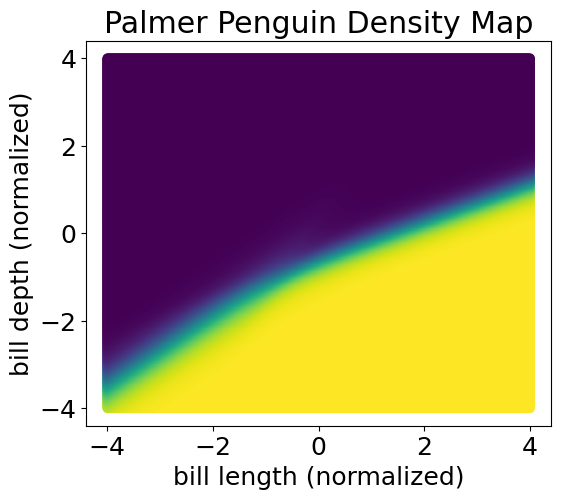

In [55]:
plt.figure(figsize=(6,5))
plt.figure(figsize=(6,5))
xs = np.linspace(-4,4,400) #np.linspace(30,60,600)
ys = xs #np.linspace(12,22,500)
Xs, Ys = np.meshgrid(xs, ys)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
gridT = grid.transpose()
gridProbs = [PDF(thing) for thing in gridT] #svm.predict_proba(gridT)
plt.scatter(grid[0], grid[1], c=gridProbs)
plt.xlabel('bill length (normalized)')
plt.ylabel('bill depth (normalized)')
plt.title("Palmer Penguin Density Map")
plt.show()

In [24]:
grads = np.array([scipy.optimize.approx_fprime(point, PDF) for point in eX])

In [25]:
Grads = torch.tensor(grads.reshape((grads.shape[0], 1, grads.shape[1]))).float()

In [26]:
#poly0 = PolynomialFeatures(2)
#B = poly0.fit_transform(X1) # we will try polynomial regression.
#resultf = OurMethod.regress(B,y1) # we can use regression instead of level set estimation.
#myF = OurMethod.invf(resultf[1], poly0, X1) #defines a class for evaluating the function, computing the jacobian.
#J = myF.Jacf(X1) # defines the Jacobian matrix at each point in the dataset.
#Js = myF.JacfSym(X1)
poly = PolynomialFeatures(2)
B = poly.fit_transform(eX)
extB = OurMethod.getExtendedFeatureMatrix2(B,Grads,2) # This makes JB*W into (JB)W: strictly matrix multiplication.
ans = OurMethod.tryDimV(extB, 1, criterion=torch.nn.L1Loss(), optimizer=moptim.rAdagrad) # look for the "best fit" generator.

/home/ben/anaconda3/lib/python3.8/site-packages/mctorch/nn/manifolds/stiefel.py:50: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272128894/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  q, r = torch.qr(X)


In [27]:
ans

(0.0017158279661089182,
 Parameter containing:
 tensor([[0.1763],
         [0.2429],
         [0.7019],
         [0.0534],
         [0.4772],
         [0.1708],
         [0.0820],
         [0.1018],
         [0.3187],
         [0.0230],
         [0.1887],
         [0.0526]], requires_grad=True))

In [28]:
def TRYDIM(V, X, Bv, polyM, d, EX=1, n_epochs=100):
    
    # This is a memory hog. Can we fix this later?
    def getExtendedFeatureMatrix2(B,J,dim):
        n = B.shape[0]
        m = B.shape[1]
        ExtArray = []
        for j in range(n):
            newBthing = np.append(B[j],np.zeros((dim-1)*m))
            Barray = np.array([np.roll(newBthing,i*m) for i in range(dim)])
            Barray = torch.tensor(Barray).float()
            thing = torch.matmul(J[j], Barray)
            #thing = np.dot(J[j],Barray)
            ExtArray.extend(thing)
        
        ExtArray = torch.stack(ExtArray, dim=0)
        #ExtArray = np.array(ExtArray)
        return ExtArray
    
    
    B0 = polyM.fit(X)
    def model(mat):
        Invf = OurMethod.invf(mat,polyM,X)
        J = Invf.Jac2f(Invf.ds, ex=EX)
        #B = Invf.featFunc.fit_transform(Invf.ds)
        extB = getExtendedFeatureMatrix2(Bv,J,dim=2)
        #extB = torch.tensor(extB).float()
        #print(Bt.shape)
        #print(V.shape)
        term1 = torch.matmul(extB, V)
        #print(term1.shape)
        #print(J.shape)
        #term2 = torch.matmul(term1, torch.transpose(J.reshape((J.shape[0],J.shape[2])),0,1))
        return term1
    
    manifold_param = mnn.Parameter(manifold=mnn.Stiefel(polyM.n_output_features_,d))    
    
    y = torch.zeros((X.shape[0],d))
    
    #optimizer = moptim.rAdagrad(params = [manifold_param], lr=1e-2)
    optimizer = moptim.rSGD(params = [manifold_param], lr=1e-2)
    criterion = torch.nn.MSELoss() #torch.nn.L1Loss() #torch.nn.MSELoss()
    for epoch in range(n_epochs):
        y_pred = model(manifold_param)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return loss.item(), manifold_param #model(manifold_param).item()

In [29]:
poly2 = PolynomialFeatures(1,include_bias=False)

In [30]:
x1 = TRYDIM(ans[1].detach(), X, B, poly2, 1, EX=0, n_epochs=1000)

In [31]:
x1

(0.0008925799047574401,
 Parameter containing:
 tensor([[-0.3927],
         [ 0.9197]], requires_grad=True))

In [32]:
ex1 = x1[1].detach().numpy()
ex1 = ex1.reshape(ex1.shape[0])
ex1

array([-0.39273083,  0.9196535 ], dtype=float32)

In [36]:
myF = OurMethod.invf(-ex1,poly2,X)

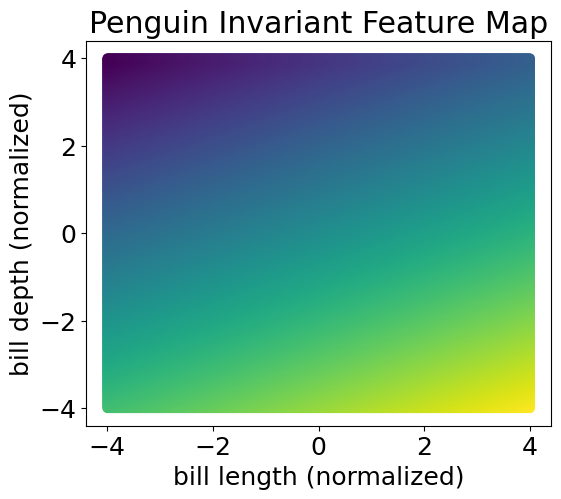

In [57]:
plt.figure(figsize=(6,5))
xs = np.linspace(-4,4,400) #np.linspace(30,60,600)
ys = xs #np.linspace(12,22,500)
Xs, Ys = np.meshgrid(xs, ys)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
gridT = grid.transpose()
PsuProbs = myF.f(np.array([grid[0],grid[1]]).transpose())
plt.scatter(grid[0], grid[1], c=PsuProbs)
plt.xlabel('bill length (normalized)')
plt.ylabel('bill depth (normalized)')
plt.title("Penguin Invariant Feature Map")
plt.show()